#### Run relevance backout here

In [1]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append("..")

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from tqdm import tqdm, trange

from util.optimization import BERTAdam
from util.processor import *

from util.tokenization import *

from util.evaluation import *

from util.train_helper import *

import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

from sklearn.metrics import classification_report

# this imports most of the helpers needed to eval the model
from run_classifier import *

sys.path.append("..")
import operator

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

RETRAIN = False
vocab_data_dir = "../../models/Transformer/vocab.txt"

#### Set-ups

In [29]:
# Note that this notebook only supports single GPU evaluation
# which is sufficient for most of tasks by using lower batch size.
IS_CUDA = False
if IS_CUDA:
    CUDA_DEVICE = "cuda:0"
    device = torch.device(CUDA_DEVICE)
    n_gpu = torch.cuda.device_count()
    logger.info("device %s in total n_gpu %d distributed training", device, n_gpu)
else:
    # bad luck, we are on CPU now!
    logger.info("gpu is out of the picture, let us use CPU")
    device = torch.device("cpu")
    
def inverse_mapping(vocab_dict):
    inverse_vocab_dict = {}
    for k, v in vocab_dict.items():
        inverse_vocab_dict[v] = k
    return inverse_vocab_dict

def translate(token_ids, vocab):
    tokens = []
    for _id in token_ids.tolist():
        tokens.append(vocab[_id])
    return tokens

def heatmap_viz(token_grad, vmin=0, cmap="Blues"):
    scores = [tu[1] for tu in token_grad]
    tokens = [tu[0] for tu in token_grad]
    fig, ax = plt.subplots(figsize=(10,1))
    ax = sns.heatmap([scores], cmap=cmap, xticklabels=tokens, yticklabels=False,
                     cbar_kws=dict(shrink=1, aspect=4, ), linewidths=0.8)
    ax.set_xticklabels(tokens, size = 18)
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)
    plt.show()
    
def evaluate_with_hooks(test_dataloader, model, device, label_list):

    # we did not exclude gradients, for attribution methods
    model.eval() # this line will deactivate dropouts
    test_loss, test_accuracy = 0, 0
    nb_test_steps, nb_test_examples = 0, 0
    pred_logits = []
    actual = []

    gs_scores = []
    gi_scores = []
    lrp_scores = []
    lat_scores = []

    inputs_ids = []
    seqs_lens = []

    # we don't need gradient in this case.
    for _, batch in enumerate(tqdm(test_dataloader, desc="Iteration")):
        input_ids, input_mask, label_ids, seq_lens = batch
        # truncate to save space and computing resource
        max_seq_lens = max(seq_lens)[0]
        input_ids = input_ids[:,:max_seq_lens]
        input_mask = input_mask[:,:max_seq_lens]

        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        label_ids = label_ids.to(device)
        seq_lens = seq_lens.to(device)

        # intentially with gradient
        tmp_test_loss, logits_raw, ctx_attn = \
            model(input_ids, input_mask, seq_lens, labels=label_ids)
        
        logits_t = F.softmax(logits_raw, dim=-1)

        logits = logits_t.detach().cpu().numpy()
        pred_logits.append(logits)
        label_ids = label_ids.to('cpu').numpy()
        actual.append(label_ids)
        outputs = np.argmax(logits, axis=1)
        tmp_test_accuracy=np.sum(outputs == label_ids)
        
        sensitivity_class = len(label_list) - 1

        # GS
        gs_score = torch.zeros(logits_t.shape)
        gs_score[:, sensitivity_class] = 1.0
        gs_score = logits_raw*gs_score
        gs_score = model.backward_gradient(gs_score)
        gs_score = torch.norm(gs_score, dim=-1)*torch.norm(gs_score, dim=-1)
        gs_scores.append(gs_score)
        
        # GI
        # gi_score = torch.zeros(logits_t.shape)
        # gi_score[:, sensitivity_class] = 1.0
        # gi_score = logits_raw*gi_score
        # gi_score = model.backward_gradient_input(gi_score)
        # gi_score = torch.norm(gi_score, dim=-1)*torch.norm(gi_score, dim=-1)
        # gi_scores.append(gi_score)

        
        # lrp
        # Rout_mask = torch.zeros((input_ids.shape[0], len(label_list))).to(device)
        # Rout_mask[:, sensitivity_class] = 1.0
        # relevance_score = logits_raw*Rout_mask
        # lrp_score = model.backward_lrp(relevance_score)
        # lrp_score = lrp_score.cpu().detach().data
        # lrp_score = torch.abs(lrp_score).sum(dim=-1)
        # lrp_scores.append(lrp_score)

        # lat
        attention_scores = model.backward_lat(input_ids, ctx_attn)
        lat_scores.append(attention_scores.sum(dim=-1))

        # other meta-data
        input_ids = input_ids.cpu().data
        seq_lens = seq_lens.cpu().data
        inputs_ids.append(input_ids)
        seqs_lens.append(seq_lens)

        test_loss += tmp_test_loss.mean().item()
        test_accuracy += tmp_test_accuracy

        nb_test_examples += input_ids.size(0)
        nb_test_steps += 1

    test_loss = test_loss / nb_test_steps
    test_accuracy = test_accuracy / nb_test_examples

    result = collections.OrderedDict()
    result = {'test_loss': test_loss,
                str(len(label_list))+ '-class test_accuracy': test_accuracy}
    logger.info("***** Eval results *****")
    for key in result.keys():
        logger.info("  %s = %s\n", key, str(result[key]))
    # get predictions needed for evaluation
    pred_logits = np.concatenate(pred_logits, axis=0)
    actual = np.concatenate(actual, axis=0)
    pred_label = np.argmax(pred_logits, axis=-1)

    attribution_scores_state_dict = dict()
    attribution_scores_state_dict["inputs_ids"] = inputs_ids
    attribution_scores_state_dict["seqs_lens"] = seqs_lens
    attribution_scores_state_dict["gs_scores"] = gs_scores
    attribution_scores_state_dict["gi_scores"] = None # TODO: enable this for transformer as well!
    attribution_scores_state_dict["lrp_scores"] = None # TODO: enable this for transformer as well!
    attribution_scores_state_dict["lat_scores"] = lat_scores

    logger.info("***** Finish Attribution Backouts *****")
    return attribution_scores_state_dict

def analysis_task(task_name, device, sentence_limit=5000):
    """
    We need to set a limit otherwise it takes too long!
    """
    task_name = task_name
    model_type = "Transformer"
    TASK_NAME = task_name
    lrp_data_dir = "../../results"
    vocab_data_dir = "../../models/Transformer/vocab.txt"
    DATA_DIR = "../../datasets/" + TASK_NAME + "/"

    # "../../data/uncased_L-12_H-768_A-12/" is for the default BERT-base pretrain
    MODEL_ROOT_PATH = "../../models/Transformer/"
    MODEL_PATH = "../../results/" + TASK_NAME + "/best_checkpoint.bin"
    EVAL_BATCH_SIZE = 24 # you can tune this down depends on GPU you have.

    # This loads the task processor for you.
    processors = {
        "SST5": SST5_Processor,
        "SemEval" : SemEval_Processor,
        "IMDb" : IMDb_Processor,
        "Yelp5" : Yelp5_Processor
    }

    processor = processors[TASK_NAME]()
    label_list = processor.get_labels()

    model, tokenizer, optimizer = \
        load_model_setups(vocab_file=MODEL_ROOT_PATH + "vocab.txt",
                           bert_config_file=None,
                           init_checkpoint=MODEL_PATH,
                           label_list=label_list,
                           num_train_steps=20,
                           do_lower_case=True,
                           # below is not required for eval
                           learning_rate=2e-5,
                           warmup_proportion=0.1,
                           init_lrp=True, 
                           model_type=model_type)
    model = model.to(device) # send the model to device

    test_examples = processor.get_test_examples(DATA_DIR, sentence_limit=sentence_limit)
    test_features = \
        convert_examples_to_features(
            test_examples,
            label_list,
            128,
            tokenizer, model_type)

    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
    all_seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)

    test_data = TensorDataset(all_input_ids, all_input_mask, all_label_ids, all_seq_len)
    test_dataloader = DataLoader(test_data, batch_size=EVAL_BATCH_SIZE, shuffle=False)
    
    score_dict = evaluate_with_hooks(test_dataloader, model, device, label_list)
    
    return score_dict

def load_attribution_scores(vocab_data_dir, inputs_ids, seqs_lens, raw_attribution_scores, min_freq=0, 
                            consider_speicial_tokens=False, normalized=True, min_length=0):
    vocab = inverse_mapping(load_vocab(vocab_data_dir, pretrain=False))
    word_lrp = {}
    word_lrp_list = []
    sentence_lrp = []
    for batch_idx in range(len(inputs_ids)):
        for seq_idx in range(inputs_ids[batch_idx].shape[0]):
            seq_len = seqs_lens[batch_idx][seq_idx].tolist()[0]
            tokens = translate(inputs_ids[batch_idx][seq_idx], vocab)[:seq_len]
            attribution_scores = raw_attribution_scores[batch_idx][seq_idx][:seq_len]
            if normalized:
                # sentence_attribution_scores = F.softmax(torch.abs(attribution_scores), dim=-1).tolist()
                sentence_max = torch.max(torch.abs(attribution_scores), dim=-1)[0]
                sentence_attribution_scores = \
                    (torch.abs(attribution_scores)/sentence_max).tolist()
            else:
                sentence_attribution_scores = attribution_scores.tolist()
            if len(tokens) >= min_length:
                assert(len(tokens) == len(sentence_attribution_scores))
                s_lrp = list(zip(tokens, sentence_attribution_scores))
                sentence_lrp.append(s_lrp)
                for i in range(len(s_lrp)):
                    token = s_lrp[i][0]
                    score = s_lrp[i][1]
                    word_lrp_list.append((token, score))
                    if token in word_lrp.keys():
                        word_lrp[token].append(score)
                    else:
                        word_lrp[token] = [score]

    filter_word_lrp = {}
    for k, v in word_lrp.items():
        if len(v) > min_freq:
            filter_word_lrp[k] = sum(v)*1.0/len(v)
    filter_word_lrp = [(k, v) for k, v in filter_word_lrp.items()] 
    filter_word_lrp.sort(key = lambda x: x[1], reverse=True)  
    word_lrp_list.sort(key = lambda x: x[1], reverse=True)
    return filter_word_lrp, word_lrp_list, sentence_lrp

def load_attribution_meta(vocab_data_dir, dataset_dict):
    attribution_meta = {}
    for item in ["gs_scores", "lat_scores"]:
        filtered_word_rank, raw_word_rank, sentence_revelance_score = \
            load_attribution_scores(vocab_data_dir,
                                    dataset_dict["inputs_ids"], 
                                    dataset_dict["seqs_lens"],
                                    dataset_dict[item])
        attribution_meta[item] = {"filtered_word_rank": filtered_word_rank, 
                                  "raw_word_rank": raw_word_rank, 
                                  "sentence_revelance_score": sentence_revelance_score}
    return attribution_meta

def plot_sentence_heatmaps(attribution_meta, n_sample=1):
    total_n = len(attribution_meta["gs_scores"]["sentence_revelance_score"])
    random_n = random.randint(0, total_n)
    sentence_heatmap_dict = dict()
    for item in ["gs_scores", "lat_scores"]:
        sentence_heatmap_dict[item] = attribution_meta[item]["sentence_revelance_score"][random_n]
        heatmap_viz(sentence_heatmap_dict[item], vmin=0)

def print_topk_words(attribution_meta, k=30, filtered=True):
    """
    print top k words for a dataset
    """
    from tabulate import tabulate
    words = []
    words_neg = []
    index = 0
    for i in range(0, k):
        item_words = []
        item_words_neg = []
        for item in ["gs_scores", "lat_scores"]:
            
            word_rank = None
            if filtered:
                word_rank = attribution_meta[item]["filtered_word_rank"]
            else:
                word_rank = attribution_meta[item]["raw_word_rank"]
            item_words.append((word_rank[i][0], round(word_rank[i][1],5) ) )
            item_words_neg.append(( word_rank[-(i+1)][0], round(word_rank[-(i+1)][1],5) ))

        words.append(item_words)
        words_neg.append(item_words_neg) # reversed ranking

    print(tabulate(words, headers=["gs_scores", "lat_scores"]))
    print("***")
    print(tabulate(words_neg, headers=["gs_scores", "lat_scores"]))

01/22/2021 14:38:32 - INFO - run_classifier -   gpu is out of the picture, let us use CPU


In [5]:
sst5_dict = analysis_task("SST5", device, sentence_limit=2000)

01/22/2021 14:25:10 - INFO - util.train_helper -   model = Transformer


loading pretrained transformer for inference


  0%|          | 0/2001 [00:00<?, ?it/s]

init_lrp = True
sentence limit= 2000
0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [00:09<00:00,  8.59it/s]
01/22/2021 14:25:21 - INFO - run_classifier -   ***** Eval results *****
01/22/2021 14:25:21 - INFO - run_classifier -     test_loss = 1.2441243344829196

01/22/2021 14:25:21 - INFO - run_classifier -     5-class test_accuracy = 0.4612693653173413

01/22/2021 14:25:21 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [6]:
semeval_dict = analysis_task("SemEval", device, sentence_limit=2000)

01/22/2021 14:25:21 - INFO - util.train_helper -   model = Transformer


loading pretrained transformer for inference


  0%|          | 0/2001 [00:00<?, ?it/s]

init_lrp = True
sentence limit= 2000
0
guid= test-0
text_a= I just went with Tom Brady 2nd overall. Did I win or...?
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [00:08<00:00,  9.80it/s]
01/22/2021 14:25:31 - INFO - run_classifier -   ***** Eval results *****
01/22/2021 14:25:31 - INFO - run_classifier -     test_loss = 0.7010798283985683

01/22/2021 14:25:31 - INFO - run_classifier -     3-class test_accuracy = 0.697151424287856

01/22/2021 14:25:31 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [3]:
imdb_dict = analysis_task("IMDb", device, sentence_limit=2000)

01/22/2021 14:24:21 - INFO - util.train_helper -   model = Transformer


loading pretrained transformer for inference
init_lrp = True


  2%|▏         | 43/2001 [00:00<00:04, 426.46it/s]

sentence limit= 2000
0
guid= test-0
text_a= This is a gem. As a Film Four production - the anticipated quality was indeed delivered. Shot with great style that reminded me some Errol Morris films, well arranged and simply gripping. It's long yet horrifying to the point it's excruciating. We know something bad happened (one can guess by the lack of participation of a person in the interviews) but we are compelled to see it, a bit like a car accident in slow motion. The story spans most conceivable aspects and unlike some documentaries did not try and refrain from showing the grimmer sides of the stories, as also dealing with the guilt of the people Don left behind him, wondering why they didn't stop him in time. It took me a few hours to get out of the melancholy that gripped me after seeing this very-well made documentary.
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [00:18<00:00,  4.49it/s]
01/22/2021 14:24:46 - INFO - run_classifier -   ***** Eval results *****
01/22/2021 14:24:46 - INFO - run_classifier -     test_loss = 0.630731850862503

01/22/2021 14:24:46 - INFO - run_classifier -     2-class test_accuracy = 0.9995002498750625

01/22/2021 14:24:46 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [4]:
yelp5_dict = analysis_task("Yelp5", device, sentence_limit=2000)

01/22/2021 14:24:48 - INFO - util.train_helper -   model = Transformer


loading pretrained transformer for inference
init_lrp = True


  3%|▎         | 53/2001 [00:00<00:03, 523.34it/s]

sentence limit= 2000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 84/84 [00:18<00:00,  4.52it/s]
01/22/2021 14:25:10 - INFO - run_classifier -   ***** Eval results *****
01/22/2021 14:25:10 - INFO - run_classifier -     test_loss = 1.1177540875616527

01/22/2021 14:25:10 - INFO - run_classifier -     5-class test_accuracy = 0.5177411294352824

01/22/2021 14:25:10 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


### Experiment 3.2.1 SST-5 Word Rank

In [ ]:
sst5_dict = analysis_task("SST5", device, sentence_limit=2000)

In [157]:
sst5_attribution_meta = load_attribution_meta(vocab_data_dir, sst5_dict)

In [158]:
print_topk_words(sst5_attribution_meta)

gs_scores                gi_scores                lrp_scores                lat_scores
-----------------------  -----------------------  ------------------------  ------------------------
('fails', 0.90606)       ('fails', 0.92061)       ('worse', 1.0)            ('.', 0.97692)
('worst', 0.83186)       ('##unk', 0.86002)       ('lacks', 0.98498)        ('?', 0.84178)
('refreshing', 0.81961)  ('##ional', 0.84693)     ('suspense', 0.98092)     ('!', 0.73134)
('##ional', 0.81286)     ('worst', 0.83212)       ('metaphor', 0.97966)     ('in', 0.70923)
('##unk', 0.79289)       ('refreshing', 0.82142)  ('pokemon', 0.9745)       ('repetitive', 0.70222)
('weak', 0.76338)        ('weak', 0.77103)        ('thriller', 0.97373)     (',', 0.65481)
('dumb', 0.75861)        ('dumb', 0.76582)        ('sentimental', 0.9709)   ('fascinating', 0.65022)
('compelling', 0.74994)  ('rare', 0.74472)        ('ultimately', 0.96888)   ('indeed', 0.63482)
('creepy', 0.7435)       ('enjoyable', 0.74252)   ('whether

In [ ]:
plot_sentence_heatmaps(sst5_attribution_meta)

### Exp. 3.2.2 Word deletion experiments

In [57]:
from random import randrange

def random_drop(input_ids_to_copy, seq_lens, k=1):
    input_ids = input_ids_to_copy.clone()
    for b in range(input_ids.shape[0]):
        if k > seq_lens[b][0]:
            input_ids[b] = 0. # zero out all of them
        else:
            zero_out_idx = random.sample(range(0, seq_lens[b][0]), k)
            for idx in zero_out_idx:
                input_ids[b][idx] = 0.
    return input_ids

def topk_drop(input_ids_to_copy, scores, new_seq_lens, k=1):
    input_ids = input_ids_to_copy.clone()
    for b in range(input_ids.shape[0]):
        if k > new_seq_lens[b][0]:
            input_ids[b] = 0.
        else:
            _, zero_out_idx = torch.topk(scores[b][:new_seq_lens[b]], k, dim=-1)
            for idx in zero_out_idx:
                input_ids[b][idx] = 0.
    return input_ids

def sentence_filter(seq_lens, min_len=0):
    sel_idx = []
    for b in range(seq_lens.shape[0]):
        if seq_lens[b][0] >= min_len:
            sel_idx.append(b)
    return sel_idx

def evaluate_with_word_deletion(test_dataloader, model, device, label_list, 
                                k=0, del_type="gi", 
                                original_correct=True,
                                min_len=10):

    # we did not exclude gradients, for attribution methods
    model.eval() # this line will deactivate dropouts
    test_loss, test_accuracy = 0, 0
    nb_test_steps, nb_test_examples = 0, 0
    pred_logits = []
    actual = []

    inputs_ids = []
    seqs_lens = []
    
    k_test_accuracy = [0.0]*k

    # we don't need gradient in this case.
    for _, batch in enumerate(tqdm(test_dataloader, desc="Iteration")):
        k_logits = []
        input_ids, input_mask, label_ids, seq_lens = batch
        # truncate to save space and computing resource
        max_seq_lens = max(seq_lens)[0]
        input_ids = input_ids[:,:max_seq_lens]
        input_mask = input_mask[:,:max_seq_lens]
        
        sel_idx = sentence_filter(seq_lens, min_len=min_len)
        
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        label_ids = label_ids.to(device)
        seq_lens = seq_lens.to(device)

        input_ids = input_ids[sel_idx]
        input_mask = input_mask[sel_idx]
        label_ids = label_ids[sel_idx]
        seq_lens = seq_lens[sel_idx]
        
        sensitivity_class = len(label_list) - 1

        tmp_test_loss, logits, ctx_attn = \
            model(input_ids, input_mask, seq_lens, labels=label_ids)

        logits_raw = F.softmax(logits, dim=-1)
        logits = logits_raw.detach().cpu().numpy()
        label_ids_raw = label_ids.to('cpu').numpy()
        outputs = np.argmax(logits, axis=1)
        tmp_idx_correct = outputs == label_ids_raw
        tmp_idx_correct = tmp_idx_correct.nonzero()[0]
        tmp_idx_wrong = outputs != label_ids_raw
        tmp_idx_wrong = tmp_idx_wrong.nonzero()[0]

        if original_correct:
            # select only those that correct
            new_input_ids = input_ids[tmp_idx_correct]
            new_input_mask = input_mask[tmp_idx_correct]
            new_seq_lens = seq_lens[tmp_idx_correct]
            new_label_ids = label_ids[tmp_idx_correct]
        else:
            # select only those that are wrong
            new_input_ids = input_ids[tmp_idx_wrong]
            new_input_mask = input_mask[tmp_idx_wrong]
            new_seq_lens = seq_lens[tmp_idx_wrong]
            new_label_ids = label_ids[tmp_idx_wrong]
            
        # corner case handling, if this batch contains no examples, we bypass
        if new_input_ids.shape[0] == 0:
            continue

        if k == 0: # no need to drop
            tmp_test_loss, logits, _ = \
                model(new_input_ids, new_input_mask, new_seq_lens, labels=new_label_ids)
        else:
            if del_type == "random":
                # Random dropouts
                for k_i in range(0, k):
                    new_input_ids_curr = random_drop(new_input_ids, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _ = \
                        model(new_input_ids_curr, new_input_mask, new_seq_lens, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "gs":
                # GS dropouts
                gs_score = torch.zeros(logits.shape)
                gs_score[:, sensitivity_class] = 1.0
                gs_score = model.backward_gradient(gs_score)
                gs_score = torch.norm(gs_score, dim=-1)*torch.norm(gs_score, dim=-1)
                if original_correct:
                    new_gs_score = gs_score[tmp_idx_correct]
                else:
                    new_gs_score = gs_score[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_gs_score, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _ = \
                        model(new_input_ids_curr, new_input_mask, new_seq_lens, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "gi":
                # GI dropouts
                gi_score = torch.zeros(logits.shape)
                gi_score[:, sensitivity_class] = 1.0
                gi_score = model.backward_gradient_input(gi_score)
                gi_score = torch.norm(gi_score, dim=-1)*torch.norm(gi_score, dim=-1)
                if original_correct:
                    new_gi_score = gi_score[tmp_idx_correct]
                else:
                    new_gi_score = gi_score[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_gi_score, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _ = \
                        model(new_input_ids_curr, new_input_mask, new_seq_lens, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "lrp":
                # lrp dropouts
                Rout_mask = torch.zeros((input_ids.shape[0], len(label_list))).to(device)
                Rout_mask[:, sensitivity_class] = 1.0
                relevance_score = logits_raw*Rout_mask
                lrp_score = model.backward_lrp(relevance_score)
                lrp_score = lrp_score.cpu().detach().data
                lrp_score = torch.abs(lrp_score).sum(dim=-1)
                if original_correct:
                    new_lrp_score = lrp_score[tmp_idx_correct]
                else:
                    new_lrp_score = lrp_score[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_lrp_score, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _ = \
                        model(new_input_ids_curr, new_input_mask, new_seq_lens, labels=new_label_ids)
                    k_logits.append(logits)
            elif del_type == "lat":
                # lat dropouts
                attention_scores = model.backward_lat(input_ids, ctx_attn)
                attention_scores = attention_scores.sum(dim=-1)
                if original_correct:
                    new_attention_scores = attention_scores[tmp_idx_correct]
                else:
                    new_attention_scores = attention_scores[tmp_idx_wrong]
                # rerun
                for k_i in range(0, k):
                    new_input_ids_curr = topk_drop(new_input_ids, new_attention_scores, new_seq_lens, k=k_i+1)
                    tmp_test_loss, logits, _ = \
                        model(new_input_ids_curr, new_input_mask, new_seq_lens, labels=new_label_ids)
                    k_logits.append(logits)
        new_label_ids = new_label_ids.to('cpu').numpy()
        for k_i in range(0, k):
            logits = k_logits[k_i]
            logits_raw = F.softmax(logits, dim=-1)
            logits = logits_raw.detach().cpu().numpy()
            outputs = np.argmax(logits, axis=1)
            tmp_test_accuracy=np.sum(outputs == new_label_ids)
            k_test_accuracy[k_i] = k_test_accuracy[k_i] + tmp_test_accuracy

        nb_test_examples += new_input_ids.size(0) # same for all the ks
        nb_test_steps += 1

    for k_i in range(0, k):
        test_accuracy = k_test_accuracy[k_i]
        test_accuracy = test_accuracy / nb_test_examples
        print("Drop words = %s, Accuracy = %.2f"%(k_i+1, test_accuracy))
    
    for k_i in range(0, k):
        test_accuracy = k_test_accuracy[k_i]
        test_accuracy = test_accuracy / nb_test_examples
        print("%.2f"%(test_accuracy))

def word_deletion_task(task_name, device, sentence_limit=2000, 
                       k=0, del_type="random",
                       original_correct=True):
    """
    We need to set a limit otherwise it takes too long!
    """
    model_type = "Transformer"
    TASK_NAME = task_name
    lrp_data_dir = "../../results"
    vocab_data_dir = "../../models/" + model_type + "/vocab.txt"
    DATA_DIR = "../../datasets/" + TASK_NAME + "/"

    # "../../data/uncased_L-12_H-768_A-12/" is for the default BERT-base pretrain
    MODEL_ROOT_PATH = "../../models/" + model_type +"/"
    MODEL_PATH = "../../results/" + TASK_NAME + "/best_checkpoint.bin"
    EVAL_BATCH_SIZE = 24 # you can tune this down depends on GPU you have.

    # This loads the task processor for you.
    processors = {
        "SST5": SST5_Processor,
        "SemEval" : SemEval_Processor,
        "IMDb" : IMDb_Processor,
        "Yelp5" : Yelp5_Processor
    }

    processor = processors[TASK_NAME]()
    label_list = processor.get_labels()
    
    model, tokenizer, optimizer = \
        load_model_setups(vocab_file=MODEL_ROOT_PATH + "vocab.txt",
                           bert_config_file=MODEL_ROOT_PATH + "bert_config.json",
                           init_checkpoint=MODEL_PATH,
                           label_list=label_list,
                           num_train_steps=20,
                           do_lower_case=True,
                           # below is not required for eval
                           learning_rate=2e-5,
                           warmup_proportion=0.1,
                           init_lrp=True ,
                           model_type=model_type)
    model = model.to(device) # send the model to device
    
    test_examples = processor.get_test_examples(DATA_DIR, sentence_limit=sentence_limit)
    test_features = \
        convert_examples_to_features(
            test_examples,
            label_list,
            128,
            tokenizer,
            model_type=model_type)

    all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
    all_seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)

    test_data = TensorDataset(all_input_ids, all_input_mask,
                              all_label_ids, all_seq_len)

    test_dataloader = DataLoader(test_data, batch_size=EVAL_BATCH_SIZE, shuffle=False)
    
    evaluate_with_word_deletion(test_dataloader, model, device, label_list, 
                                k=k, del_type=del_type, 
                                original_correct=original_correct)

In [55]:
# processors = {
#     "SST5": SST5_Processor,
#     "SemEval" : SemEval_Processor,
#     "IMDb" : IMDb_Processor,
#     "Yelp5" : Yelp5_Processor
# }
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("SST5", device, sentence_limit=1000, 
                   k=i, del_type="random", 
                   original_correct=True)

01/22/2021 15:08:25 - INFO - util.train_helper -   model = Transformer


===== Word Deletion with Max K=10 =====
loading pretrained transformer for inference


  0%|          | 0/1001 [00:00<?, ?it/s]

init_lrp = True
sentence limit= 1000
0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


Iteration: 100%|██████████| 42/42 [00:10<00:00,  3.86it/s]

Drop words = 1, Accuracy = 0.94
Drop words = 2, Accuracy = 0.91
Drop words = 3, Accuracy = 0.88
Drop words = 4, Accuracy = 0.80
Drop words = 5, Accuracy = 0.74
Drop words = 6, Accuracy = 0.74
Drop words = 7, Accuracy = 0.66
Drop words = 8, Accuracy = 0.67
Drop words = 9, Accuracy = 0.61
Drop words = 10, Accuracy = 0.54
0.94
0.91
0.88
0.80
0.74
0.74
0.66
0.67
0.61
0.54


In [58]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("SST5", device, sentence_limit=1000, 
                   k=i, del_type="gs", 
                   original_correct=True)

01/22/2021 15:09:33 - INFO - util.train_helper -   model = Transformer


===== Word Deletion with Max K=10 =====
loading pretrained transformer for inference


  0%|          | 0/1001 [00:00<?, ?it/s]

init_lrp = True
sentence limit= 1000
0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


Iteration: 100%|██████████| 42/42 [00:13<00:00,  3.22it/s]

Drop words = 1, Accuracy = 0.78
Drop words = 2, Accuracy = 0.68
Drop words = 3, Accuracy = 0.58
Drop words = 4, Accuracy = 0.52
Drop words = 5, Accuracy = 0.44
Drop words = 6, Accuracy = 0.38
Drop words = 7, Accuracy = 0.35
Drop words = 8, Accuracy = 0.35
Drop words = 9, Accuracy = 0.32
Drop words = 10, Accuracy = 0.31
0.78
0.68
0.58
0.52
0.44
0.38
0.35
0.35
0.32
0.31


In [ ]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("SST5", device, sentence_limit=1000, 
                   k=i, del_type="gi", 
                   original_correct=True)

In [ ]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("SST5", device, sentence_limit=1000, 
                   k=i, del_type="lrp", 
                   original_correct=True)

In [59]:
i = 10
print("===== Word Deletion with Max K=%s ====="%(i))
word_deletion_task("SST5", device, sentence_limit=1000, 
                   k=i, del_type="lat", 
                   original_correct=True)

01/22/2021 15:10:02 - INFO - util.train_helper -   model = Transformer


===== Word Deletion with Max K=10 =====
loading pretrained transformer for inference


  0%|          | 0/1001 [00:00<?, ?it/s]

init_lrp = True
sentence limit= 1000
0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


Iteration: 100%|██████████| 42/42 [00:10<00:00,  3.87it/s]

Drop words = 1, Accuracy = 0.80
Drop words = 2, Accuracy = 0.68
Drop words = 3, Accuracy = 0.61
Drop words = 4, Accuracy = 0.55
Drop words = 5, Accuracy = 0.46
Drop words = 6, Accuracy = 0.41
Drop words = 7, Accuracy = 0.37
Drop words = 8, Accuracy = 0.34
Drop words = 9, Accuracy = 0.31
Drop words = 10, Accuracy = 0.30
0.80
0.68
0.61
0.55
0.46
0.41
0.37
0.34
0.31
0.30


### Exp. 3.4 Correlations across datasets
Due to the memory limitation and cache limitations, we want run these analysis function 1 at a time to avoid failure.

In [5]:
sst5_dict = analysis_task("SST5", device, sentence_limit=2000)

12/30/2020 15:27:05 - INFO - util.train_helper -   model = BERT
12/30/2020 15:27:05 - INFO - util.train_helper -   *** Model Config ***
12/30/2020 15:27:05 - INFO - util.train_helper -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



init_weight = True
init_lrp = True


 20%|█▉        | 392/2001 [00:00<00:00, 3919.61it/s]

sentence limit= 2000
0
guid= test-0
text_a= no movement , no yuks , not much of anything .
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [07:56<00:00,  5.68s/it]
12/30/2020 15:35:05 - INFO - run_classifier -   ***** Eval results *****
12/30/2020 15:35:05 - INFO - run_classifier -     test_loss = 1.0573235069002425

12/30/2020 15:35:05 - INFO - run_classifier -     5-class test_accuracy = 0.5727136431784108

12/30/2020 15:35:05 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [6]:
semeval_dict = analysis_task("SemEval", device, sentence_limit=2000)

12/30/2020 15:35:05 - INFO - util.train_helper -   model = BERT
12/30/2020 15:35:05 - INFO - util.train_helper -   *** Model Config ***
12/30/2020 15:35:05 - INFO - util.train_helper -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



init_weight = True
init_lrp = True


  8%|▊         | 160/2001 [00:00<00:01, 1599.40it/s]

sentence limit= 2000
0
guid= test-0
text_a= I just went with Tom Brady 2nd overall. Did I win or...?
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [09:42<00:00,  6.93s/it]
12/30/2020 15:44:51 - INFO - run_classifier -   ***** Eval results *****
12/30/2020 15:44:51 - INFO - run_classifier -     test_loss = 0.6267894499358677

12/30/2020 15:44:51 - INFO - run_classifier -     3-class test_accuracy = 0.7351324337831084

12/30/2020 15:44:51 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [7]:
imdb_dict = analysis_task("IMDb", device, sentence_limit=2000)

12/30/2020 15:44:51 - INFO - util.train_helper -   model = BERT
12/30/2020 15:44:51 - INFO - util.train_helper -   *** Model Config ***
12/30/2020 15:44:51 - INFO - util.train_helper -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



init_weight = True
init_lrp = True


  2%|▏         | 39/2001 [00:00<00:05, 378.93it/s]

sentence limit= 2000
0
guid= test-0
text_a= This is a gem. As a Film Four production - the anticipated quality was indeed delivered. Shot with great style that reminded me some Errol Morris films, well arranged and simply gripping. It's long yet horrifying to the point it's excruciating. We know something bad happened (one can guess by the lack of participation of a person in the interviews) but we are compelled to see it, a bit like a car accident in slow motion. The story spans most conceivable aspects and unlike some documentaries did not try and refrain from showing the grimmer sides of the stories, as also dealing with the guilt of the people Don left behind him, wondering why they didn't stop him in time. It took me a few hours to get out of the melancholy that gripped me after seeing this very-well made documentary.
text_b= None
label= 1


Iteration: 100%|██████████| 84/84 [17:49<00:00, 12.73s/it]
12/30/2020 16:02:48 - INFO - run_classifier -   ***** Eval results *****
12/30/2020 16:02:48 - INFO - run_classifier -     test_loss = 0.35495261941659484

12/30/2020 16:02:48 - INFO - run_classifier -     2-class test_accuracy = 0.8845577211394303

12/30/2020 16:02:48 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [8]:
yelp5_dict = analysis_task("Yelp5", device, sentence_limit=2000)

12/30/2020 16:02:48 - INFO - util.train_helper -   model = BERT
12/30/2020 16:02:48 - INFO - util.train_helper -   *** Model Config ***
12/30/2020 16:02:48 - INFO - util.train_helper -   {
  "attention_probs_dropout_prob": 0.1,
  "full_pooler": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



init_weight = True
init_lrp = True


  2%|▏         | 45/2001 [00:00<00:04, 449.09it/s]

sentence limit= 2000
0
guid= test-0
text_a= Don't waste your time.  We had two different people come to our house to give us estimates for a deck (one of them the OWNER).  Both times, we never heard from them.  Not a call, not the estimate, nothing.
text_b= None
label= 0


Iteration: 100%|██████████| 84/84 [16:29<00:00, 11.78s/it]
12/30/2020 16:19:25 - INFO - run_classifier -   ***** Eval results *****
12/30/2020 16:19:25 - INFO - run_classifier -     test_loss = 0.8283675302352224

12/30/2020 16:19:25 - INFO - run_classifier -     5-class test_accuracy = 0.632183908045977

12/30/2020 16:19:25 - INFO - run_classifier -   ***** Finish Attribution Backouts *****


In [9]:
# save it to disk to avoid repeatitive runs
torch.save(sst5_dict, "./sst5_dict.pt")
torch.save(semeval_dict, "./semeval.pt")
torch.save(imdb_dict, "./imdb.pt")
torch.save(yelp5_dict, "./yelp5.pt")

In [2]:
# you can just load this for your second time
sst5_dict = torch.load("./sst5.pt")
semeval_dict = torch.load("./semeval.pt")
imdb_dict = torch.load("./imdb.pt")
yelp5_dict = torch.load("./yelp5.pt")

In [20]:
def find_common_vocab(dict_list):
    assert len(dict_list) > 0
    common_vocab = set(dict_list[0].keys())
    for i in range(1, len(dict_list)):
        common_vocab = common_vocab.intersection(set(dict_list[i].keys()))
    return common_vocab

def subset_score(dict_list):
    common_vocab = find_common_vocab(dict_list)
    per_word_score = []
    for word in common_vocab:
        word_score = []
        for d in dict_list:
            word_score.append(d[word])
        per_word_score.append(word_score)
    return np.transpose(np.array(per_word_score)) 

def common_word_scores(attribution_method, vocab_data_dir, 
                       sst5_dict, semeval_dict, imdb_dict, yelp5_dict):
    attribution_method = attribution_method + "_scores"
    
    sst_filtered_word_rank, sst_raw_word_rank, sst_sentence_revelance_score = \
        load_attribution_scores(vocab_data_dir,
                                sst5_dict["inputs_ids"], 
                                sst5_dict["seqs_lens"],
                                sst5_dict[attribution_method])
    semeval_filtered_word_rank, semeval_raw_word_rank, semeval_sentence_revelance_score = \
        load_attribution_scores(vocab_data_dir,
                                semeval_dict["inputs_ids"], 
                                semeval_dict["seqs_lens"],
                                semeval_dict[attribution_method])
    imdb_filtered_word_rank, imdb_raw_word_rank, imdb_sentence_revelance_score = \
        load_attribution_scores(vocab_data_dir,
                                imdb_dict["inputs_ids"], 
                                imdb_dict["seqs_lens"],
                                imdb_dict[attribution_method])
    yelp5_filtered_word_rank, yelp5_raw_word_rank, yelp5_sentence_revelance_score = \
        load_attribution_scores(vocab_data_dir,
                                yelp5_dict["inputs_ids"], 
                                yelp5_dict["seqs_lens"],
                                yelp5_dict[attribution_method])
    sst_dict = dict()
    semeval_dict = dict()
    imdb_dict = dict()
    yelp5_dict = dict()
    for e in sst_filtered_word_rank:
        sst_dict[e[0]] = e[1]
    for e in semeval_filtered_word_rank:
        semeval_dict[e[0]] = e[1]
    for e in imdb_filtered_word_rank:
        imdb_dict[e[0]] = e[1]
    for e in yelp5_filtered_word_rank:
        yelp5_dict[e[0]] = e[1]
    score_list = subset_score([sst_dict, semeval_dict, imdb_dict, yelp5_dict])
    score_df = pd.DataFrame({"SST-5": score_list[0], "SemEval": score_list[1],
                             "IMDb": score_list[2], "Yelp-5": score_list[3]})
    return score_df

In [30]:
gs_score_df = common_word_scores("gs", vocab_data_dir, 
                                 sst5_dict, semeval_dict, imdb_dict, yelp5_dict)
# gi_score_df = common_word_scores("gi", vocab_data_dir, 
#                                  sst5_dict, semeval_dict, imdb_dict, yelp5_dict)
# lrp_score_df = common_word_scores("lrp", vocab_data_dir, 
#                                   sst5_dict, semeval_dict, imdb_dict, yelp5_dict)
lat_score_df = common_word_scores("lat", vocab_data_dir, 
                                  sst5_dict, semeval_dict, imdb_dict, yelp5_dict)

In [22]:
def corr_plot(score_df, color="red"):
    import matplotlib.pyplot as plt
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = "black"
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['axes.labelsize'] = 30

    import matplotlib 
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)

    from scipy.stats import pearsonr
    def reg_coef(x,y,label=None,color=None,**kwargs):
        ax = plt.gca()
        r,p = pearsonr(x,y)
        ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center', size=30)
        ax.set_axis_off()

    g = sns.PairGrid(score_df)
    g.map_diag(sns.distplot, color=color)
    g.map_lower(sns.regplot, marker="+", line_kws={"color": "black"}, color=color)
    g.map_upper(reg_coef)

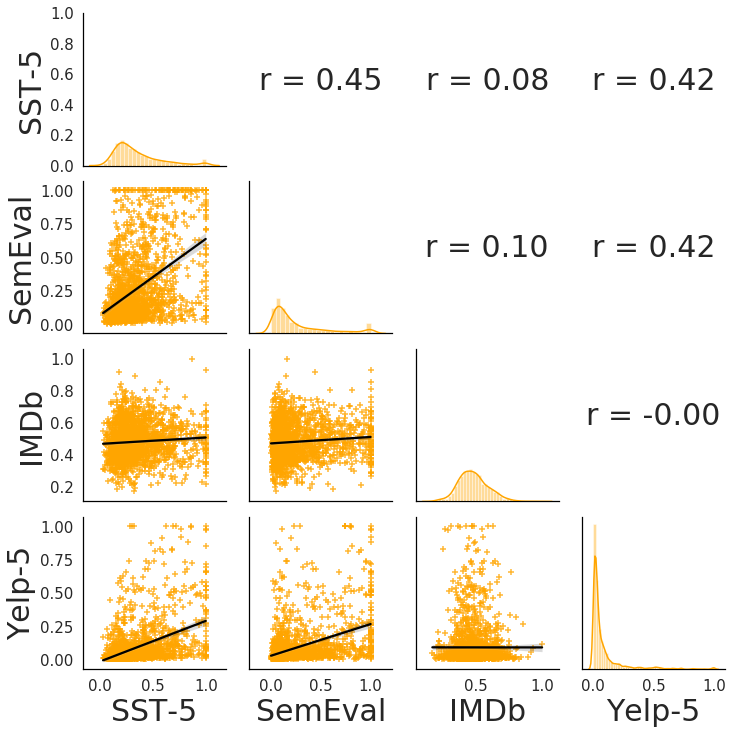

In [31]:
corr_plot(gs_score_df, "orange")

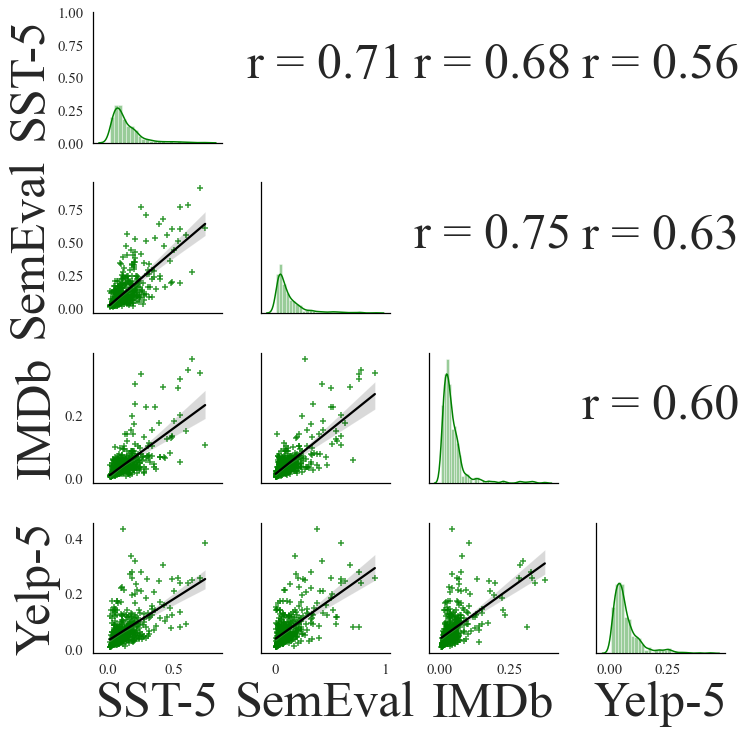

In [47]:
corr_plot(gi_score_df, "green")

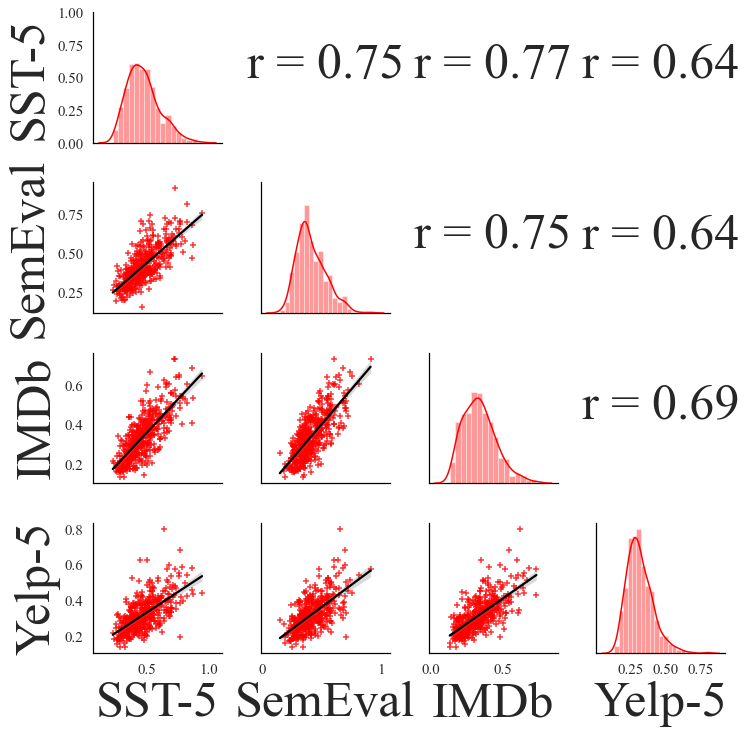

In [48]:
corr_plot(lrp_score_df, "red")

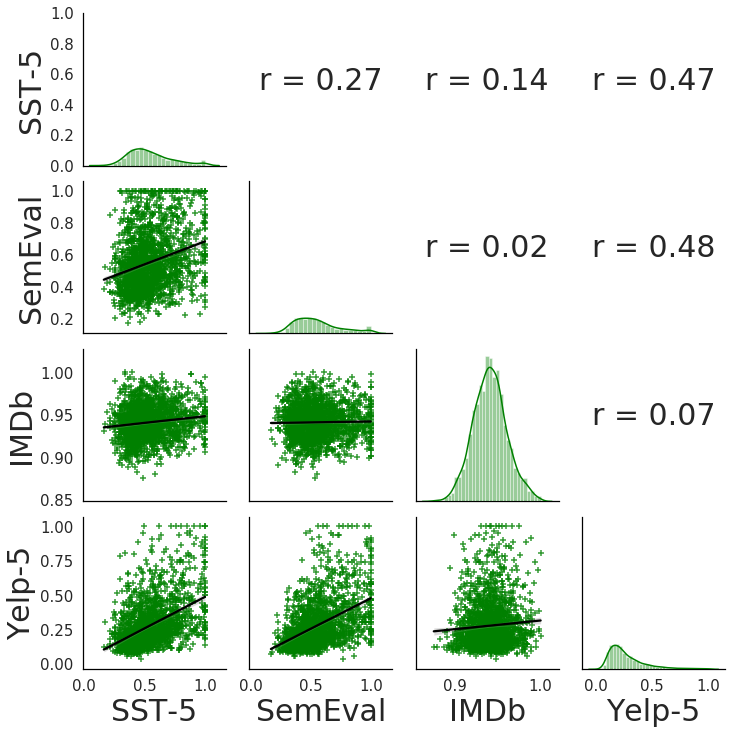

In [33]:
corr_plot(lat_score_df, "green")